# 0.0 IMPORTS

In [1]:
import random
import warnings
import pandas      as pd
import numpy       as np
import seaborn     as sns

import matplotlib.pyplot as plt
from sklearn.metrics         import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn                import under_sampling as us
from imblearn                import under_sampling as us
from scipy                   import stats as ss
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing as pp
from sklearn                 import metrics       as m
from keras                   import models as ml
from keras                   import layers as l
from IPython.core.display    import HTML

warnings.filterwarnings( 'ignore' )

In [ ]:
from pandas-profiling import 

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2 Loading Data

In [41]:
df_raw = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/train_users.csv', low_memory=True) 

df_sessions = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/sessions.csv', low_memory=True)


# 1.0 Passo 01 - DESCRIÇÃO DOS DADOS

In [42]:
df1 = df_raw.copy()
df1_sessions = df_sessions.copy()

## 1.1 Data Dimensions

In [43]:
print(f'Número de linhas é igual a: {df1.shape[0]}')
print(f'Número de colunas é igual a: {df1.shape[1]}')

Número de linhas é igual a: 213451
Número de colunas é igual a: 16


In [44]:
#Sessions
print(f'Número de linhas é igual a: {df1_sessions.shape[0]}')
print(f'Número de colunas é igual a: {df1_sessions.shape[1]}')

Número de linhas é igual a: 10567737
Número de colunas é igual a: 6


## 1.2 Data Types

In [45]:
#Data types df1
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [46]:
#Data types df1_sessions
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [47]:
df1.isna().sum() /len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [49]:
df1_sessions.isna().sum()/len(df1_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [12]:
df1['first_affiliate_tracked'].drop_duplicates()
#aux = df1[df1[ 'age'].isna()]
#aux['country_destination'].value_counts(normalize=True)

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [50]:
#Remover NAs
# =====================USERS======================================

#date_first_booking
date_first_booking_max =  pd.to_datetime( df1['date_first_booking']).max().strftime('%Y%m%d')

df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max)


#age: Preencher como valor médio
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna( avg_age).astype(int)

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]


#============================================SESSIONS=========================================
#user_id        3%
df1_sessions = df1_sessions[~df1_sessions['user_id'].isna()]

#action         0.7%
df1_sessions = df1_sessions[~df1_sessions['action'].isna()]

#action_type    11%
df1_sessions = df1_sessions[~df1_sessions['action_type'].isna()]

#action_detail  11%
df1_sessions = df1_sessions[~df1_sessions['action_detail'].isna()]

#secs_elapsed   1.2%
df1_sessions = df1_sessions[~df1_sessions['secs_elapsed'].isna()]

In [51]:
df1.isna().sum() / len( df1 )

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [52]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4 Change Data Types

In [53]:
df1.dtypes

id                         object
date_account_created       object
timestamp_first_active      int64
date_first_booking         object
gender                     object
age                         int32
signup_method              object
signup_flow                 int64
language                   object
affiliate_channel          object
affiliate_provider         object
first_affiliate_tracked    object
signup_app                 object
first_device_type          object
first_browser              object
country_destination        object
dtype: object

In [54]:
#date_account_created   
df1['date_account_created']=pd.to_datetime( df1['date_account_created'])
#timestamp_first_active  
df1['timestamp_first_active']=pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking']=pd.to_datetime( df1['date_first_booking'])
#age                      
df1['age']= df1['age'].astype('int64')


## 1.5 Check Balanced Data

In [55]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive Analyses

In [56]:
#==================Users===================================
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes( include= ['datetime64[ns]'])


#====================Sessions==========================================
num_attributes_sessions  = df1_sessions.select_dtypes( include=['int64', 'float64'])
cat_attributes_sessions  = df1_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df1_sessions.select_dtypes( include= ['datetime64[ns]'])

### 1.6.1 Numerical -Users

In [57]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.1 Numerical -Sessions

In [58]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes_sessions.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame( num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame( num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.2 Numerical - Users

In [59]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.3 Categorical -Sessions

In [60]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [61]:
#lista de atributos para cramer v
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for i in range( len(cat_attributes_list) ):
    corr_list = []
    
    for j in range (len(cat_attributes_list ) ):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        #Correlação
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat] )
        
        #append a list
        corr_list.append( corr )
    # append correlation para cada ref atrtibuts
    corr_dict[ref] = corr_list

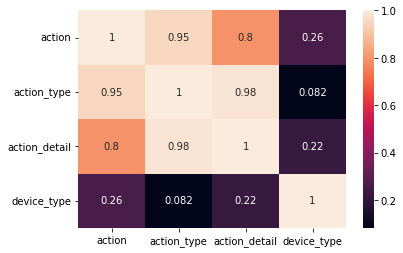

In [62]:
d = pd.DataFrame( corr_dict)
d = d.set_index(d.columns)
sns.heatmap( d, annot=True);

# 2.0 PASSO 02 - Feature Engeneering


In [65]:
df2 =df1.copy()
df2.dtypes


id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [66]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 2.1 Create new Features

In [67]:
# days from first activate up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime("%Y-%m-%d") )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] -df2['first_active']).apply( lambda x: x.days)

#days from first activate up to account create
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] -df2['first_active']).apply( lambda x: x.days)

#days from account create up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] -df2['date_account_created']).apply( lambda x: x.days)
    

#===================================First activate======================================
#Year first active
df2['year_first_active'] = df2['first_active'].dt.year

#Month first active
df2['month_first_active'] = df2['first_active'].dt.month


#Day first active
df2['day_first_active'] = df2['first_active'].dt.day


#Day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek


#Week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#===================================Booking======================================
#Year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#Month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#Day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#Day of Week of first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#Week of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear


#===================================First account created======================================
#Year first active
df2['year_account_created'] = df2['date_account_created'].dt.year

#Month first active
df2['month_account_created'] = df2['date_account_created'].dt.month


#Day first active
df2['day_account_created'] = df2['date_account_created'].dt.day


#Day of week first active
df2['day_of _week_first_account_created'] = df2['date_account_created'].dt.dayofweek


#Week of year first active
df2['week_of _year_first_account_created'] = df2['date_account_created'].dt.weekofyear




In [68]:
df2.shape

(122636, 35)

# 3.0 PASSO 03 - Data Filtering


In [87]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [88]:
#Age:entre 15 e 120 pois há poucas pessoas como mais de 120 anos
df3 =  df3[( df2['age']> 15) & (df3['age'] < 120 )]

# secs_elapsed - Não há possibilidade de ter 0 elapsed
#df1_sessions = df1_sessions[ df1_sessions['secs_elapsed']> 0]

## 3.2 Columns Selection

# 4.0 - DATA PREPARATION

In [89]:
df4 = df3.copy()

In [90]:
# Dummy Variable
df4_dummy = pd.get_dummies( df4.drop( ['id','country_destination'], axis=1 ) )

#Join ID and country_destiantion
df4 =pd.concat( [  df4[['id', 'country_destination']], df4_dummy],axis=1)

In [91]:
df4.shape

(122636, 144)

# 5.0 Feature Selection

In [92]:
#Deletar as colunas desnecessarias pro modelo
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active']
df5= df4.drop(cols_drop, axis=1)

In [93]:
X = df5.drop(['id', 'country_destination'], axis=1)
y = df5['country_destination'].copy()

In [94]:
#Split dataset
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 ) 

# 6.0 MACHINE LEARNING MODEL

In [96]:
x_train = X_train
x_test = X_test

## 6.1 Baseline Model 

In [97]:
#random.choices(populacao =, weght= , k=)
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().to_list()
k_num = y_test.shape[0]
country_destination_weghts = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

# Modelo aleatório
yhat_random = random.choices(population= country_destination_list, 
                             weights = country_destination_weghts,
                             k = k_num)


### 6.1.1 Baseline Model Performance

Accuracy: 0.35836594911937375
Balanced Accuracy: 0.08058683144647373
Balanced Accuracy: -0.0007701038193528298


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.01      0.01      0.01       164
          ES       0.01      0.01      0.01       319
          FR       0.02      0.02      0.02       736
          GB       0.01      0.01      0.01       361
          IT       0.01      0.01      0.01       420
         NDF       0.45      0.45      0.45     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.39      0.39      9606
       other       0.06      0.06      0.06      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



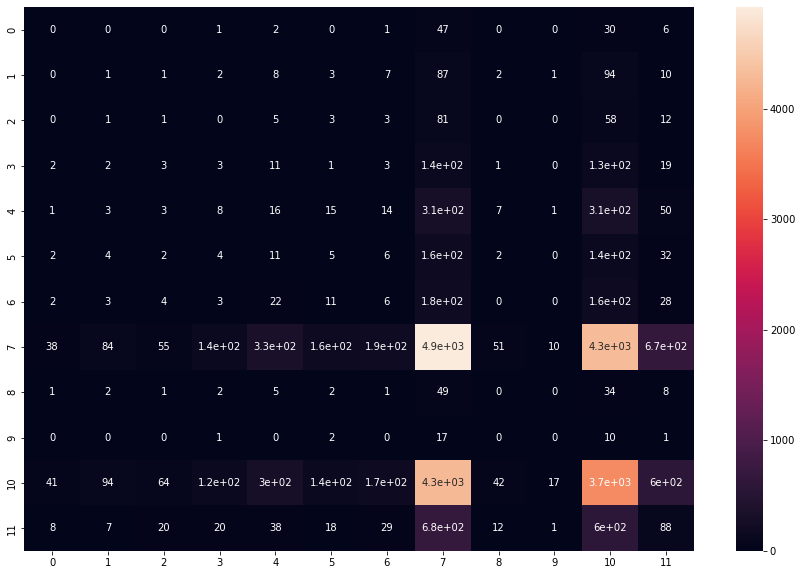

In [98]:
#Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

#Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

#Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Balanced Accuracy: {kappa_random}')
print('\n')

#Classification Report
print(m.classification_report(y_test, yhat_random))

#Confusion Matrix
cm = confusion_matrix( y_test, yhat_random)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);


## 5.2 Neural Network - MLP

In [99]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1 ) ).toarray()

In [100]:
#df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

In [101]:
# Model definition
model = ml.Sequential()
model.add(l.Dense( 256, input_dim=x_train.shape[1], activation='relu') )
model.add(l.Dense( 12, activation='softmax') )

#Model compile
model.compile( loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'] )

#training model
model.fit( x_train , y_train_nn, epochs=100 )

Epoch 1/100
3066/3066 [==============================] - 27s 1ms/step - loss: 11.2645 - accuracy: 0.7224
Epoch 2/100
3066/3066 [==============================] - 4s 1ms/step - loss: 2.5178 - accuracy: 0.7548
Epoch 3/100
3066/3066 [==============================] - 4s 1ms/step - loss: 1.2071 - accuracy: 0.7877
Epoch 4/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.8697 - accuracy: 0.8116
Epoch 5/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.7035 - accuracy: 0.8338
Epoch 6/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6512 - accuracy: 0.8384
Epoch 7/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6492 - accuracy: 0.8372
Epoch 8/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6454 - accuracy: 0.8380
Epoch 9/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6426 - accuracy: 0.8382
Epoch 10/100
3066/3066 [==============================] - 4s 1ms/step -

In [102]:
#Predict
pred_nn = model.predict( x_test )

#invert prediction
yhat_nn = ohe.inverse_transform( pred_nn)

#Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn =  yhat_nn.reshape(1, -1 )[0]

Accuracy: 0.8383480104370515
Balanced Accuracy: 0.16662329099868137
Kappa score: 0.7230314158664942


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.00      0.00      0.00       164
          ES       0.00      0.00      0.00       319
          FR       0.00      0.00      0.00       736
          GB       0.00      0.00      0.00       361
          IT       0.00      0.00      0.00       420
         NDF       1.00      1.00      1.00     10962
          NL       0.00      0.00      0.00       105
          PT       0.00      0.00      0.00        31
          US       0.71      1.00      0.83      9606
       other       0.00      0.00      0.00      1521

    accuracy                           0.84     24528
   macro avg       0.14      0.17      0.15     24528
weighted avg       0.72      0.84      0.77     24528



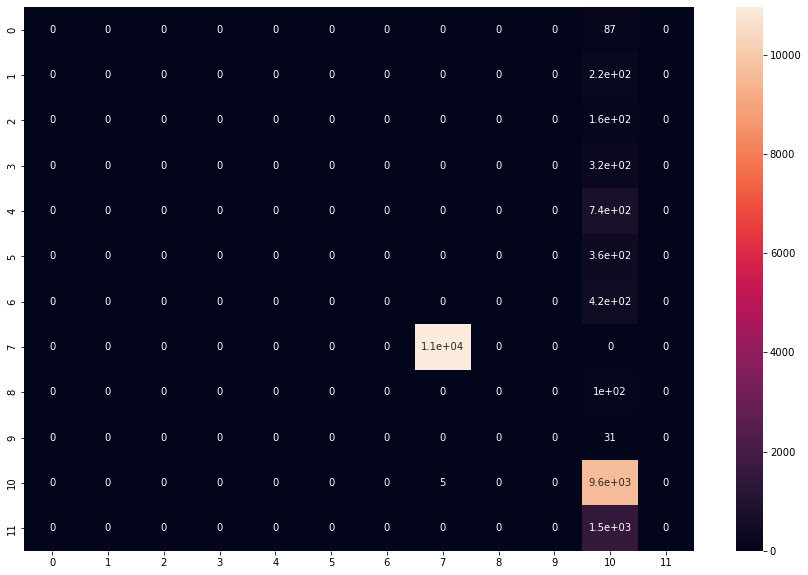

In [103]:
#Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

#Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

#Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')
print('\n')

#Classification Report
print(m.classification_report(y_test_nn, yhat_nn))

#Confusion Matrix
cm = confusion_matrix( y_test_nn, yhat_nn)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);



## 5.2.3 NN Performance - Cross Validation

In [108]:
#Generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split(x_train, y_train):
    print(f'Fold number {i}/{num_folds}\n')
    #Get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
   
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    #target hot_encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape( -1, 1)).toarray()
    
    #Model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))
    
    #Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    
    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform( pred_nn)
    
    #prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1)[0]
    
    #metrics
    
    #Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn)
   
    #Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn)
    
    i += 1

Fold number 1/5

Fold number 2/5

Fold number 3/5

Fold number 4/5

Fold number 5/5



In [109]:
print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}\n')
      
print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')

Avg Balanced Accuracy: 0.16664716137850932 +/- 1.4376268742616218e-05

Avg Kappa: 0.7243067118422054 +/- 0.0001348824715870761


## 4.1 Random Undersampling

In [110]:
# Ratio_balanced
ratio_balanced = {'NDF': 10000}

#Para fazer reamostragem : definir um sampler
undersampling = us.RandomUnderSampler(sampling_strategy='auto', random_state=32)

#aplicar o sampler
X_under, y_under = undersampling.fit_resample(df41, df4['country_destination'])

In [111]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [112]:
y_under.value_counts()

AU       157
CA       157
DE       157
ES       157
FR       157
GB       157
IT       157
NDF      157
NL       157
PT       157
US       157
other    157
Name: country_destination, dtype: int64

## 4.2 Random Oversampling

## 4.3 Smote + Tomeklink